<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

# General overview of using dianna

DIANNA is a Python package that brings explainable AI (XAI) to your research project. It wraps carefully selected XAI methods (explainers) in a simple, uniform interface. It's built by, with and for (academic) researchers and research software engineers working on machine learning projects.

This overview illustrates the main strenghts of DIANNA, namely supporting many data modalities and several explainers. DIANNA is future-proof by supporting and advocating the ONNX de-facto standard for Neural Network models. Many modern frameworks alpready support native export to ONNX, for tutorials on conversion from PyTorch, Keras, Scikit-learn and TensorFlow see [conversion_onnx](https://github.com/dianna-ai/dianna/tree/main/tutorials/conversion_onnx) folder. 

## **General workflow**

1. Provide your *trained model* and *data item* ( *text, image, time series or tabular* )

```python
model_path = 'your_model.onnx'  # model trained on your data modality
data_item = <data_item> # data item for which the model's prediction needs to be explained 
```

2. If the task is classification: which are the *classes* your model has been trained for?

```python 
labels = [class_a, class_b]   # example of binary classification labels
```
*Which* of these classes do you want an explanation for?
```python
explained_class_index = labels.index(<explained_class>)  # explained_class can be any of the labels
```

3. Run dianna with the *explainer* of your choice ( *'LIME', 'RISE' or 'KernalSHAP'*) and visualize the output:

```python
explanation = dianna.<explanation_function>(model_path, data_item, explainer)
dianna.visualization.<visualization_function>(explanation[explained_class_index], data_item)
```

### Setting up

#### Colab Setup

In [1]:
running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
  # install dianna
  !python3 -m pip install dianna[notebooks]
  
  # download data used in this demo
  import os 
  base_url = 'https://raw.githubusercontent.com/dianna-ai/dianna/main/dianna/'
  paths_to_download = ['./data/binary-mnist.npz', './models/mnist_model_tf.onnx']
  for path in paths_to_download:
      !wget {base_url + path} -P {os.path.dirname(path)}
    
  paths_to_download = ['./data/movie_reviews_word_vectors.txt', './models/movie_review_model.onnx']
  for path in paths_to_download:
      !wget {base_url + path} -P {os.path.dirname(path)}    

  base_url = 'https://raw.githubusercontent.com/dianna-ai/dianna/main/dianna/'
  paths_to_download = ['./data/bee.jpg']
  for path in paths_to_download:
      !wget {base_url + path} -P {os.path.dirname(path)}

#### Libraries

In [2]:
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore') # disable warnings relateds to versions of tf

import numpy as np

# for explanation and visualization
import dianna
from dianna import visualization
from dianna import utils as dianna_utils
from dianna.utils.tokenizers import SpacyTokenizer

# ONNX
import onnx
import onnxruntime
from onnx_tf.backend import prepare

# text-related
import spacy
from torchtext.vocab import Vectors
from scipy.special import softmax
from scipy.special import expit as sigmoid

# keras model and preprocessing tools for Image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras import backend as K
from keras import utils as keras_utils

# visualizations
import matplotlib.pyplot as plt
%matplotlib inline

import random
random.seed(42)

2024-05-27 16:31:47.005677: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-27 16:31:47.051186: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 16:31:47.051222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 16:31:47.053279: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-27 16:31:47.064299: I tensorflow/core/platform/cpu_feature_guar

## **Data modalities**
DIANNA supports text, images, time-series and tabular data.

### Text example* 

Lets illustrate the general worksflow above with *textual* data. The data item of interest is a sentence being (a part of) a movie review and the [model](https://zenodo.org/record/5910598) has been trained to classify the movie reviews from the [Stanford sentiment treebank](https://nlp.stanford.edu/sentiment/index.html) <img width="20" alt="nlp-logo_half_size" src="https://user-images.githubusercontent.com/3244249/152355020-908c04f3-aa99-489d-b87a-7e6b1f586118.png"> into 'positive' and 'negative' sentiment classes.
We are interested in which words are contributing positively (red) and which - negatively (blue) towards the model's decision to classify the review as positive and we would like to use the [LIME](https://www.kdd.org/kdd2016/papers/files/rfp0573-ribeiroA.pdf) explainer:

*for a full example see the /Explainers/LIME/lime_text tutorial

1. Provide your *trained model* and *text* of interest.

In [3]:
# model paths and labels
model_path = Path('..','dianna','models', 'movie_review_model.onnx')
word_vector_path = Path('..','dianna','labels', 'movie_reviews_word_vectors.txt')
labels = ("negative", "positive")

The classifier accepts numerical tokens as input and outputs a score between 0 (the review is negative) and 1 (the review is positive).
Therefore, we define a model runner class, which accepts a sentence as input instead and returns one of two classes: negative or positive.

In [4]:
# ensure the tokenizer for english is available
spacy.cli.download('en_core_web_sm')

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 20.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
class MovieReviewsModelRunner:
    def __init__(self, model, word_vectors, max_filter_size):
        self.run_model = dianna_utils.get_function(str(model))
        self.vocab = Vectors(word_vectors, cache=os.path.dirname(word_vectors))
        self.max_filter_size = max_filter_size
        
        self.tokenizer =  SpacyTokenizer(name='en_core_web_sm')

    def __call__(self, sentences):
        # ensure the input has a batch axis
        if isinstance(sentences, str):
            sentences = [sentences]

        tokenized_sentences = []
        for sentence in sentences:
            # tokenize and pad to minimum length
            tokens = self.tokenizer.tokenize(sentence.lower())
            if len(tokens) < self.max_filter_size:
                tokens += ['<pad>'] * (self.max_filter_size - len(tokens))
            
            # numericalize the tokens
            tokens_numerical = [self.vocab.stoi[token] if token in self.vocab.stoi else self.vocab.stoi['<unk>']
                                for token in tokens]
            tokenized_sentences.append(tokens_numerical)
            
        # run the model, applying a sigmoid because the model outputs logits
        logits = self.run_model(tokenized_sentences)
        pred = np.apply_along_axis(sigmoid, 1, logits)
        
        # output two classes
        positivity = pred[:, 0]
        negativity = 1 - positivity
        return np.transpose([negativity, positivity])

In [6]:
# define model runner. max_filter_size is a property of the model
model_runner = MovieReviewsModelRunner(model_path, word_vector_path, max_filter_size=5)

Define a sentence of interest:

In [7]:
review = "A delectable and intriguing thriller filled with surprises"


   2. Which are the classes your model has been trained for? Which of these classes do you want an explanation for?

In [8]:
labels = ("negative", "positive")  # sentiments of the movie reviews
explained_class_index = labels.index("positive")  # we are interested why our sentence is classified as having a positive sentiment
explained_class_index
labels.index('positive')

1


  3.  Run dianna with the explainer of your choice, 'LIME', and visualize the output. For textual data use the ```explain_text``` function.


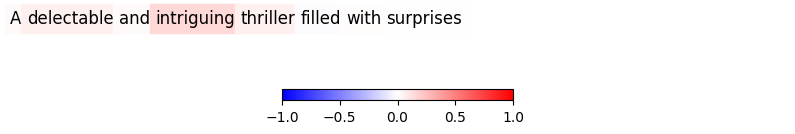

In [9]:
explanation = dianna.explain_text(model_runner, review, model_runner.tokenizer,'LIME', labels=[explained_class_index])[0]
explanation
fig, _ = visualization.highlight_text(explanation, model_runner.tokenizer.tokenize(review), colormap='bwr')

### Image example*

Here we apply the general workflow with image data from <img width="94" alt="ImageNet_autocrop" src="https://user-images.githubusercontent.com/3244249/152542090-fd78fde1-6dec-43b6-a7ae-eea964b8ae28.png">. The data item of interest is an image of a bee and we use the [ResNet 50](https://arxiv.org/abs/1512.03385) model trained on [Imagenet](https://image-net.org/download.php) to classify 1000 types of objects. We are interested in which pixels are contributing positively (red) and which - negatively (blue) towards the model's decision to classify the image as a 'bee' and we would like to use the [RISE](http://bmvc2018.org/contents/papers/1064.pdf) explainer:

*for a full example see the /Explainers/RISE/rise_imagenet tutorial

1. Provide your *trained model* and *image* of interest.

Initialize the pretrained model.

In [10]:
class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = ResNet50()
        self.input_size = (224, 224)
        
    def run_on_batch(self, x):
        return self.model.predict(x)

model = Model()

Load and preprocess the 'bee' image.

In [11]:
def load_img(path):
    img = keras_utils.load_img(path, target_size=model.input_size)
    x = keras_utils.img_to_array(img)
    preproc_img = preprocess_input(x)
    return img, preproc_img 

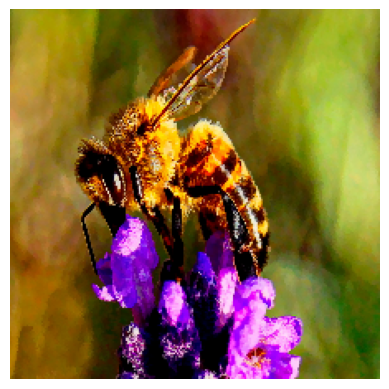

In [12]:
img, preproc_img = load_img(Path('..','dianna','data', 'bee.jpg'))
fig, ax = plt.subplots() 
ax.axis('off')
plt.imshow(img)

 2. Which are the classes your model has been trained for? Which of these classes do you want an explanation for?

In [13]:
labels = [range(1000)]  # 1000 classes of objects
# we are interested why our image is classified as a 'bee'
def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]
for i in range(1000):    
    if class_name(i) == 'bee':
        explained_class_index = i
print(explained_class_index)
print(class_name(explained_class_index))

309
bee


3.  Run dianna with the explainer of your choice, 'RISE', and visualize the output. For image use the ```explain_image``` function.

RISE masks random portions of the input image and passes the masked image through the model — the masked portion that decreases accuracy the most is the most “important” portion.To call the explainer and generate relevance scores map, the user need to specifiy the number of masks being randomly generated (`n_masks`), the resolution of features in masks (`feature_res`) and for each mask and each feature in the image, the probability of being kept unmasked (`p_keep`).

In [14]:
explanation = dianna.explain_image(model.run_on_batch, preproc_img, method="RISE", labels=[i for i in range(1000)],      
                                   n_masks=1000, feature_res=6, p_keep=.1, axis_labels={2: 'channels'})

Explaining:   0%|                                                                                | 0/10 [00:00<?, ?it/s]

4/4 [==============================] - 4s 648ms/step


Explaining:  10%|███████▏                                                                | 1/10 [00:03<00:35,  3.90s/it]

4/4 [==============================] - 3s 755ms/step


Explaining:  20%|██████████████▍                                                         | 2/10 [00:07<00:28,  3.59s/it]

4/4 [==============================] - 7s 2s/step


Explaining:  30%|█████████████████████▌                                                  | 3/10 [00:14<00:35,  5.03s/it]

4/4 [==============================] - 6s 1s/step


Explaining:  40%|████████████████████████████▊                                           | 4/10 [00:20<00:32,  5.48s/it]

4/4 [==============================] - 6s 1s/step


Explaining:  50%|████████████████████████████████████                                    | 5/10 [00:26<00:28,  5.79s/it]

4/4 [==============================] - 6s 1s/step


Explaining:  60%|███████████████████████████████████████████▏                            | 6/10 [00:32<00:23,  6.00s/it]

4/4 [==============================] - 6s 1s/step


Explaining:  70%|██████████████████████████████████████████████████▍                     | 7/10 [00:39<00:18,  6.11s/it]

4/4 [==============================] - 6s 1s/step


Explaining:  80%|█████████████████████████████████████████████████████████▌              | 8/10 [00:45<00:12,  6.06s/it]

4/4 [==============================] - 6s 1s/step


Explaining:  90%|████████████████████████████████████████████████████████████████▊       | 9/10 [00:51<00:06,  6.14s/it]

4/4 [==============================] - 6s 1s/step


Explaining: 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.79s/it]


Make predictions and check the top 5 predictions.

In [15]:
predictions = model.model.predict(preproc_img[None, ...])
# print the index and name of the top predicted class, taking care of adding a batch axis to the model input
print("Top predicted class index: ", np.argmax(predictions))
print("Top 5 predicted class name: ", class_name(np.argmax(predictions)))

prediction_ids = np.argsort(predictions)[0][-1:-6:-1]
print("Top 5 predicted class indicies:", prediction_ids)
print("Top 5 predicted class names:")
for class_idx in prediction_ids:
    print(class_name(class_idx))


1/1 [==============================] - 0s 226ms/step
Top predicted class index:  309
Top 5 predicted class name:  bee
Top 5 predicted class indicies: [309 946 308 319  74]
Top 5 predicted class names:
bee
cardoon
fly
dragonfly
garden_spider


Our model has predicted the image class correctly. Visualize the relevance scores for the 'bee' class.

Explanation for `bee` (0.9229555130004883)


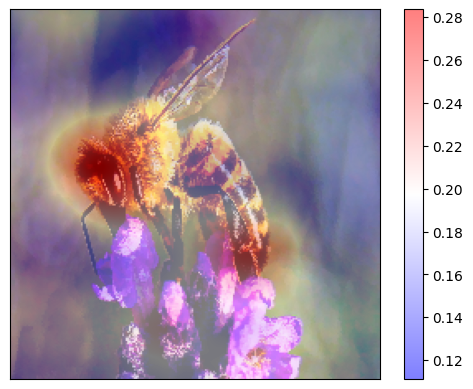

In [16]:
print(f'Explanation for `{class_name(explained_class_index)}` ({predictions[0][explained_class_index]})')
visualization.plot_image(explanation[explained_class_index], keras_utils.img_to_array(img)/255., heatmap_cmap='bwr')
plt.show()

What would make our model think that the image is one of a 'garden_spider'?

Explanation for `garden_spider` (0.005400052759796381)


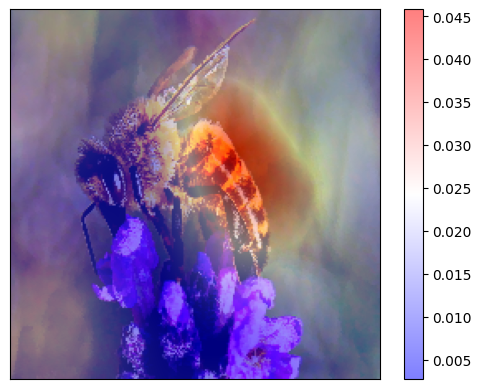

In [17]:
another_class_index = 74  # the fifth prediciton was 'garden_spider'
print(f'Explanation for `{class_name(another_class_index)}` ({predictions[0][another_class_index]})')
visualization.plot_image(explanation[another_class_index], keras_utils.img_to_array(img)/255., heatmap_cmap='bwr')
plt.show()

### Time series example*

Here we apply the general workflow on time series (TS) data representing spectographs of two types of coffee beans: Robusta and Arabica.  The model trained on the [Coffee dataset](https://www.timeseriesclassification.com/description.php?Dataset=Coffee) classies the beans brand. We are interested in which datapoints are contributing positively (red) and which - negatively (blue) towards the model's decision to classify the TS using the [LIME](https://www.kdd.org/kdd2016/papers/files/rfp0573-ribeiroA.pdf) explainer:

*for a full example see the /Explainers/LIME/lime_timeseries_coffee tutorial

## **Explainers**
DIANNA supports [RISE](http://bmvc2018.org/contents/papers/1064.pdf), [LIME](https://www.kdd.org/kdd2016/papers/files/rfp0573-ribeiroA.pdf) and [KernalSHAP](https://proceedings.neurips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf) explainability methods. This section demonstrates how to run all the supported explainers for the simple binary classification task of distinguishing the hand-written digits "0" and "1" on test example from the Binary MNIST dataset, a subset of the [MNIST benchmark](http://yann.lecun.com/exdb/mnist/). It also gives the basics for each of the explainers.

###  Explaining a Pretrained Binary MNIST Classification Model 

Load the Binary MNIST data, the pretrained [binary MNIST model](https://zenodo.org/record/5907177) and chose image to be explained.

In [18]:
# load dataset
data_path = Path('..', 'dianna','data', 'binary-mnist.npz')
data = np.load(data_path)
# load testing data and the related labels
X_test = data['X_test'].astype(np.float32).reshape([-1, 28, 28, 1]) / 256
y_test = data['y_test']

In [19]:
# Load saved onnx model
onnx_model_path = Path('..','dianna','models', 'mnist_model_tf.onnx')
onnx_model = onnx.load(onnx_model_path)
# get the output node
output_node = prepare(onnx_model, gen_tensor_dict=True).outputs[0]

Print class and image of a single instance in the test data for preview.

The predicted class for this test image is: digit 0


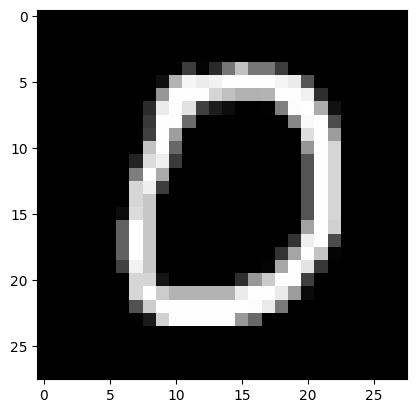

In [20]:
# class name
class_name = ['digit 0', 'digit 1']
# instance index
i_instance = 3
# select instance for testing
test_sample = X_test[i_instance]
# model predictions with added batch axis to test sample
predictions = prepare(onnx_model).run(test_sample[None, ...])[f'{output_node}']
pred_class = class_name[np.argmax(predictions)]
# get the index of predictions
top_preds = np.argsort(-predictions)
inds = top_preds[0]
print("The predicted class for this test image is:", pred_class)
plt.imshow(X_test[i_instance][:,:,0], cmap='gray')  # 0 for channel

#### 1. KernelSHAP

SHapley Additive exPlanations, in short, SHAP, is a model-agnostic explainable AI approach which is used to decrypt the black-box models through estimating the [Shapley values](https://en.wikipedia.org/wiki/Shapley_value), which represent the relevancies of each data feature (image pixel, word in text, etc.). [KernelSHAP](https://proceedings.neurips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf) is a variant of SHAP. It is a method that uses the LIME framework to compute Shapley Values, and visualizes the relevance attributions for each pixel/super-pixel by displaying them on an image. <br>

The user needs to specify the number model re-evaluations when explaining each prediction (`nsamples`). A binary mask need to be applied to the image indicating whihc image regiona are hidden. It requires the background color for the masked image, which can be specified by `background`.<br>

Performing KernelSHAP for each pixel is inefficient. It is always a good practice to segment the input image to super-pixels and perform computations on them. The user has to specify some keyword arguments related to the segmentation: the (approximate) number of labels in the segmented output image (`n_segments`), and width of Gaussian smoothing kernel for pre-processing for each image dimension (`sigma`).

In [21]:
# use KernelSHAP to explain the network's predictions
shap_values = dianna.explain_image(onnx_model_path, test_sample,
                                  method="KernelSHAP", labels=[0], nsamples=1000,
                                  background=0, n_segments=200, sigma=0,
                                  axis_labels=('height','width','channels'))

  0%|          | 0/1 [00:00<?, ?it/s]

Visualize the relevance scores of each pixel on the images.

Explaination for `digit 0` with KernelSHAP


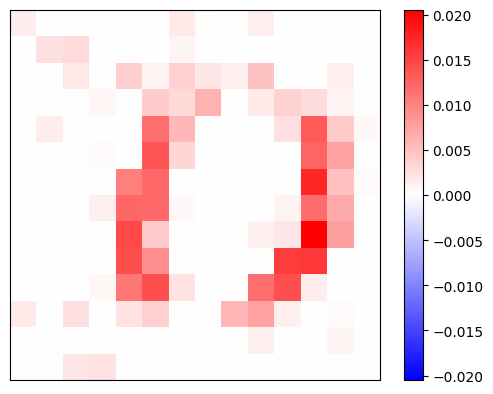

In [22]:
# Visualize the explanations
# get the range for color bar
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
# plot the test image and the attributions on the image for class 0
print(f'Explaination for `{pred_class}` with KernelSHAP')

fig, _ = visualization.plot_image(shap_values[0], heatmap_cmap='bwr', heatmap_range=(-max_val, max_val))


The Shapley scores are estimated using KernelSHAP for models used to categorize the binary MNIST. The example here shows that the KernelSHAP method evaluates the importance of each segmentation/super pixel to the classification and the results are reasonably comparable to the human visual preception of the chosen testing hand-written digit image.

#### 2. RISE

RISE is short for Randomized Input Sampling for Explanation of Black-box Models. It estimates the relevance empirically by probing the model with randomly masked versions of the input image to obtain the corresponding outputs.<br>


RISE masks random portions of the input image and passes the masked image through the model — the portion that decreases the accuracy the most is the most “important” portion.<br>
To call the explainer and generate the relevance scores, the user need to specified the number of masks being randomly generated (`n_masks`), the resolution of features in masks (`feature_res`) and for each mask and each feature in the image, the probability of being kept unmasked (`p_keep`).

In [23]:
relevances = dianna.explain_image(onnx_model_path, test_sample, method="RISE",
                                labels=[i for i in range(2)],
                                n_masks=5000, feature_res=8, p_keep=.1,
                                axis_labels=('height','width','channels'))[0]

Explaining: 100%|███████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.35it/s]


Visualize the relevance scores for the predicted class on top of the image.

Explaination for `digit 0` with RISE


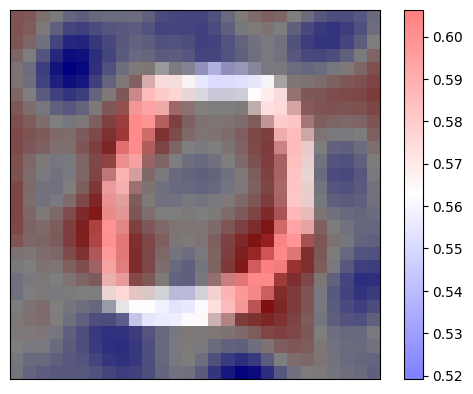

In [24]:
print(f'Explaination for `{pred_class}` with RISE')
fig, _ = visualization.plot_image(relevances, X_test[i_instance][:,:,0], data_cmap='gray', heatmap_cmap='bwr')

#### 3. LIME

LIME (Local Interpretable Model-agnostic Explanations) is an explainable-AI method that aims to create an interpretable model that locally represents the classifier.


In [25]:
# need to preprocess, because we divided the input data by 256 for the models and LIME needs RGB values
def preprocess_function(image):
    return (image / 256).astype(np.float32)

# An explanation is returned for each label, but we ask for just one label so the output is a list of length one.
explanation_heatmap = dianna.explain_image(onnx_model_path, test_sample * 256, 'LIME',
                                           axis_labels=('height','width','channels'),
                                           random_state=2,
                                           labels=[i for i in range(2)], preprocess_function=preprocess_function)

  0%|          | 0/5000 [00:00<?, ?it/s]

Explaination for `digit 0` with LIME


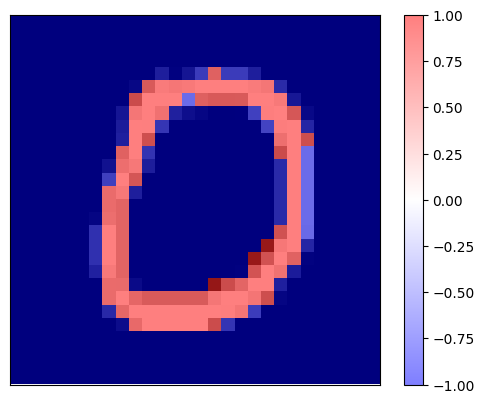

In [26]:
print(f'Explaination for `{pred_class}` with LIME')
fig, _ = visualization.plot_image(explanation_heatmap[0], X_test[i_instance][:,:,0], heatmap_cmap='bwr')
